In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from toolbox import wrappers
from toolbox import network_utilities
import repos_tools
import pandas as pd
import numpy as np
import scipy.stats

GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


Read network and mapping betwen gene IDs and symbols

In [2]:
id_mapping_file = '../../resources/PPI/geneid_to_symbol.txt'
network = wrappers.get_network('../../resources/PPI/Cheng2019/network.sif', only_lcc = True)
id_symbol = pd.read_csv(id_mapping_file, sep='\t', index_col='GeneID')
id_symbol = id_symbol.set_index(id_symbol.index.astype('str'))

From Andrew's manuscript on repurposing asthma drugs to AD:
> Approved drugs, or drugs in development, target the protein products of 15 of the 81 genes as identified using the ChEMBL database [28]. Among these are GRIN3A, PDE4D, and IL6R. The glutamate ionotropic NMDA receptor subunit NR3A is encoded by GRIN3A and has been previously associated with AD as targeted by an existing approved AD treatment, Memantine [29]. Phosphodiesterase-4 (PDE4) has been considered a promising target for treatment of AD and depression and functions as an existing target for current asthma medication [30], [31]. Asthma is the trait of interest in this study, thus we have focused on drugs shown to be effective in it’s treatment such as Roflumilast targeting PDE4D. Through the use of STRINGDB protein-protein interaction network we selected additional asthma drugs targeting proteins with scores >= 0.500 from those within our implicated list [27]. This included approved asthma drugs such as Salbutamol targeting beta-2 adrenergic receptor ADRB2, Montelukast targeting cysteinyl leukotriene receptor 1 CYSLTR1, and Fluticasone which targets the glucocorticoid receptor NR3C1.

In [3]:
%%bash
cat > ../../results/2021-09-02-asthma-drugs/asthma-drug-targets <<EOF
GRIN3A
PDE4D
IL6R
ADRB2
CYSLTR1
NR3C1
EOF

In [4]:
targets = wrappers.convert_to_geneid(file_name='../../results/2021-09-02-asthma-drugs/asthma-drug-targets', id_type='symbol', id_mapping_file=id_mapping_file)
d = id_symbol.loc[targets, 'Symbol'].to_dict()
Targets = {v: {k} for k, v in d.items()}
Targets

set()


{'GRIN3A': {'116443'},
 'CYSLTR1': {'10800'},
 'ADRB2': {'154'},
 'PDE4D': {'5144'},
 'IL6R': {'3570'},
 'NR3C1': {'2908'}}

In [5]:
gset_names = ['knowledge', 'knowledge-TWAS2plus', 'knowledge-TWAS', 'knowledge-TWAS2plus-IAPS']
def read_geneset(name):
    file_name = '../../results/2021-07-01-high-conf-ADgenes/AD-genes-' + name
    gset = wrappers.convert_to_geneid(file_name=file_name, id_type='symbol', id_mapping_file=id_mapping_file)
    gset, gset_dropped = repos_tools.drop_genes_notin_network(gset, network)
    return(gset)

Genesets = {k: read_geneset(k) for k in gset_names}

{'MT-ND2', 'MT-ND1'}
{'MT-ND2', 'MT-ND1'}
{'MT-ND2', 'AC099524.1', 'CTD-2380F24.1', 'AL512631.1', 'FAM115D', 'ENSG00000260911', 'RTFDC1', 'GATS', 'ENSG00000270081.1', 'RP11-385F7.1', 'CTB-129P6.11', 'X84075', 'AC087500.1', 'MT-ND1'}
{'MT-ND2', 'MT-ND1'}


Calculate proximity

In [6]:
def helper(target, geneset, network):
    res = wrappers.calculate_proximity(network=network, nodes_from=target, nodes_to=geneset)
    return(res)

def dict2df(d, condition):
    l = [[v[0], v[1], v[2][0], v[2][1]] for v in d.values()]
    a = np.array(l)
    ix = pd.MultiIndex.from_product([[condition], d.keys()])
    # z = (d - mean_0) / std_0
    df = pd.DataFrame(a, columns=['d', 'z', 'mean_0', 'std_0'], index=ix)
    df['p'] = df['z'].apply(lambda x: scipy.stats.norm.sf(-x))
    df = df.rename_axis(['condition', 'target'], axis=0)
    return(df)

Prox = {gname: dict2df({tname: helper(targ, gset, network) for tname, targ in Targets.items()}, gname) for gname, gset in Genesets.items()}

In [7]:
prox = pd.concat(Prox.values(), axis=0)
prox.to_csv('../../results/2021-09-02-asthma-drugs/proximity-results.csv')
prox['condition'] = pd.MultiIndex.get_level_values(prox.index, level='condition')
prox['target'] = pd.MultiIndex.get_level_values(prox.index, level='target')
prox

d         z  mean_0     std_0         p  \
condition                target                                               
knowledge                GRIN3A   2.0  0.031155   1.992  0.256780  0.512427   
                         CYSLTR1  4.0  2.976754   2.368  0.548248  0.998543   
                         ADRB2    2.0  1.682682   1.261  0.439180  0.953782   
                         PDE4D    1.0 -1.814344   1.767  0.422742  0.034812   
                         IL6R     1.0 -3.185085   1.926  0.290730  0.000724   
                         NR3C1    1.0 -0.591209   1.259  0.438086  0.277190   
knowledge-TWAS2plus      GRIN3A   2.0  0.152656   1.953  0.307881  0.560665   
                         CYSLTR1  4.0  3.123908   2.343  0.530425  0.999108   
                         ADRB2    2.0  2.098906   1.185  0.388298  0.982087   
                         PDE4D    1.0 -1.665408   1.735  0.441333  0.047916   
                         IL6R     1.0 -3.087178   1.911  0.295092  0.001010   
                         NR3C1    1.0 -0.496873   1.198  0.398492  0.309639   
knowledge-TWAS           GRIN3A   2.0  0.285175   1.907  0.326115  0.612245   
                         CYSLTR1  3.0  1.313492   2.276  0.551202  0.905491   
                         ADRB2    2.0  3.086473   1.095  0.293215  0.998987   
                         PDE4D    1.0 -1.336232   1.641  0.479707  0.090737   
                         IL6R     1.0 -2.479231   1.868  0.350109  0.006583   
                         NR3C1    1.0 -0.292876   1.079  0.269739  0.384808   
knowledge-TWAS2plus-IAPS GRIN3A   2.0  0.343032   1.869  0.381889  0.634213   
                         CYSLTR1  3.0  1.484833   2.248  0.506454  0.931206   
                         ADRB2    1.0 -0.284747   1.075  0.263391  0.387919   
                         PDE4D    1.0 -1.109014   1.569  0.513068  0.133712   
                         IL6R     1.0 -2.233388   1.833  0.372976  0.012762   
                         NR3C1    1.0 -0.263664   1.065  0.246526  0.396019   

                                                 condition   target  
condition                target                                      
knowledge                GRIN3A                  knowledge   GRIN3A  
                         CYSLTR1                 knowledge  CYSLTR1  
                         ADRB2                   knowledge    ADRB2  
                         PDE4D                   knowledge    PDE4D  
                         IL6R                    knowledge     IL6R  
                         NR3C1                   knowledge    NR3C1  
knowledge-TWAS2plus      GRIN3A        knowledge-TWAS2plus   GRIN3A  
                         CYSLTR1       knowledge-TWAS2plus  CYSLTR1  
                         ADRB2         knowledge-TWAS2plus    ADRB2  
                         PDE4D         knowledge-TWAS2plus    PDE4D  
                         IL6R          knowledge-TWAS2plus     IL6R  
                         NR3C1         knowledge-TWAS2plus    NR3C1  
knowledge-TWAS           GRIN3A             knowledge-TWAS   GRIN3A  
                         CYSLTR1            knowledge-TWAS  CYSLTR1  
                         ADRB2              knowledge-TWAS    ADRB2  
                         PDE4D              knowledge-TWAS    PDE4D  
                         IL6R               knowledge-TWAS     IL6R  
                         NR3C1              knowledge-TWAS    NR3C1  
knowledge-TWAS2plus-IAPS GRIN3A   knowledge-TWAS2plus-IAPS   GRIN3A  
                         CYSLTR1  knowledge-TWAS2plus-IAPS  CYSLTR1  
                         ADRB2    knowledge-TWAS2plus-IAPS    ADRB2  
                         PDE4D    knowledge-TWAS2plus-IAPS    PDE4D  
                         IL6R     knowledge-TWAS2plus-IAPS     IL6R  
                         NR3C1    knowledge-TWAS2plus-IAPS    NR3C1

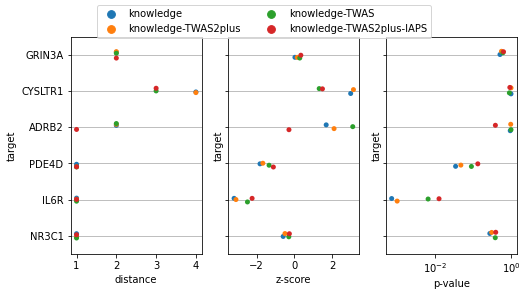

In [8]:
fig, ax = repos_tools.plot_proximity_results(prox.drop(['mean_0', 'std_0'], axis=1))

In [9]:
%connect_info

{
  "shell_port": 56106,
  "iopub_port": 56107,
  "stdin_port": 56108,
  "control_port": 56110,
  "hb_port": 56109,
  "ip": "127.0.0.1",
  "key": "a2a0c69f-ffb89ce64bce850ecc4d4d20",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0e6a42fe-1d0d-484b-9bc7-f2bbdfd5fdc8.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
